<a href="https://colab.research.google.com/github/Dichik/gathers-nlp-final-project/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sentence_transformers

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TOKENIZERS_PARALLELISM"]="true"
import calendar

import pandas as pd
import numpy as np 
import gensim
import nltk
import spacy
import re
import torch
import torch.nn as nn

from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk import tokenize
from wordcloud import WordCloud, STOPWORDS
from functools import reduce
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from copy import deepcopy
import json

%matplotlib inline

/home/diakap/miniconda3/envs/ai_house_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/diakap/miniconda3/envs/ai_house_env/lib/python3.9/site-packages/torch/cuda/__init__.py:529: UserWarning: HIP initialization: Unexpected error from hipGetDeviceCount(). Did you run some cuda functions before calling NumHipDevices() that might have already set an error? Error 101: hipErrorInvalidDevice (Triggered internally at ../c10/hip/HIPFunctions.cpp:110.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


In [2]:
def read_file(path: str):
    f = open(path)
    data = json.load(f)
    
    date_info = []
    dataset = []
    for i in data:
        try:
            text = i.get('message')
            dt = i.get('date')
            dataset.append(text)
            date_info.append(dt)
        except:
              print('error')
    
    f.close()
    return pd.DataFrame({'Message': dataset, 'Date': date_info})

In [3]:
regular_news = read_file('channel_messages_trypy2.json')
poss_manipulations = read_file('channel_messages_trypy.json')

In [4]:
regular_news.head()

Message  \
0  ⚡️російські спецслужби намагались отримати дан...   
1  🥹Українська правозахисниця голова громадської ...   
2  🔥 Вибухи під москвою\n\nБавовна і пожежа. Це ч...   
3  😵‍💫 лавров не зміг потрапити на конференцію в ...   
4                                                      

                        Date  
0  2023-03-02T21:50:01+00:00  
1  2023-03-02T21:31:01+00:00  
2  2023-03-02T21:11:00+00:00  
3  2023-03-02T20:50:01+00:00  
4  2023-03-02T20:34:31+00:00

In [5]:
poss_manipulations.head()

Message  \
0  ⏺#ЦПД_виявляє: протягом 02.03.2023 окупанти по...   
1  #ЦПД_аналізує спроби кремля примусити Захід та...   
2  ⚡️#ЦПД_інформує: основний наратив, що сьогодні...   
3  #ЦПД_інформує про дезінформаційні та маніпулят...   
4  #ЦПД_аналізує досьє пропагандиста в.манучарова...   

                        Date  
0  2023-03-02T19:30:10+00:00  
1  2023-03-02T17:00:05+00:00  
2  2023-03-02T14:51:30+00:00  
3  2023-03-02T11:49:05+00:00  
4  2023-03-02T09:12:05+00:00

In [6]:
poss_manipulations.dropna(inplace=True)

In [7]:
manipulation_news = poss_manipulations[poss_manipulations['Message'].str.contains('Маніпуляці')]


In [8]:
def preclean_text(df, type_text="manipulation"):
    if type_text == 'manipulation':
        manipulation = []
        for i, item in df.iterrows():
            if item[0] is None:
                continue
            for i in range(len(item[0].split('\n'))):
                text = item[0].split('\n')
                if 'Маніп' in text[i]:
                    if 'заявив, що' in text[i+1]:
                        text_split = text[i+1].split('заявив, що')
                        manipulation.append(text_split[1])
                    elif 'заявили, що' in text[i]:
                        text_split = text[i+1].split('заявили, що')
                        manipulation.append(text_split[1])
                    elif 'заявили:' in text[i+1]:
                        text_split = text[i+1].split('заявили:')
                        manipulation.append(text_split[1])
                    elif 'заявив:' in text[i+1]:
                        text_split = text[i+1].split('заявив:')
                        manipulation.append(text_split[1])
                    elif 'повідомив, що' in text[i+1]:
                        text_split = text[i+1].split('повідомив, що')
                        manipulation.append(text_split[1])
                    elif 'повідомили, що' in text[i+1]:
                        text_split = text[i+1].split('повідомили, що')
                        manipulation.append(text_split[1])
                    elif 'повідомив:' in text[i+1]:
                        text_split = text[i+1].split('повідомив:')
                        manipulation.append(text_split[1])
                    elif 'повідомили:' in text[i+1]: 
                        text_split = text[i+1].split('повідомили:')
                        manipulation.append(text_split[1])
                    else:
                        text_split = text[i+1]
                        manipulation.append(text_split)
                        
        return pd.DataFrame({'Message': list(set(manipulation))})
                    
    if type_text == 'normal':
        normal = []
        for i, item in df.iterrows():
            if item[0] is None:
                continue
            elif 'тривога' in item[0]:
                continue
            elif 'вибух' in item[0]:
                continue
            
            elif '——' in item[0]:
                    text_split = item[0].split('——')
                    normal.append(text_split[0])
            elif '____' in item[0]:
                    text_split = item[0].split('____')
                    normal.append(text_split[0])
            else:
                    text_split = item[0]
                    normal.append(text_split)
    
        return pd.DataFrame({'Message': list(set(normal))})

In [9]:
df_manipulation = preclean_text(poss_manipulations, type_text='manipulation')
df_normal = preclean_text(regular_news, type_text='normal')

In [10]:
df_manipulation.iloc[1].values[0]

'❌ ЗМІ рф заявили, що «на територіях, що стали підконтрольними Україні, дуже складна ситуація. У містах відсутня електрика, вода, опалення… Влада України не збирається вирішувати цю проблему. Єдине, що вони запропонували, – «добровільна евакуація». '

In [11]:
df_manipulation['Message'].astype(bool).sum()

505

In [12]:
df_manipulation['Message'] = df_manipulation[df_manipulation['Message'].astype(bool)]

In [13]:
df_manipulation.dropna(inplace=True)

In [14]:
df_manipulation.reset_index(drop=True, inplace=True)

In [15]:
df_manipulation.head()

Message
0  ❌ ЗМІ рф заявили, що «на територіях, що стали ...
1  ❌ російський депутат є.федоров пригрозив відкл...
2  ❌ В МО рф розповіли про американський проект «...
3   «влада впроваджує високі технології у військо...
4  ❌ «Рішення поставити Україні «деяку кількість ...

In [16]:
df_normal.head()

Message
0                                                   
1  🪖 Британська розвідка стверджує, що росії брак...
2  В результаті обстрілів міста Олешки повибивало...
3  Ось так виглядає Київ під час снігопаду\n\nФот...
4  ❤️Томарине, що на Херсонщині, також під контро...

In [17]:
df_normal['is_manipulation'] = 0
df_manipulation['is_manipulation'] = 1

In [18]:
dataset = pd.concat([df_normal, df_manipulation])

df = pd.DataFrame(dataset)
df.reset_index(inplace=True)
df.head()

index                                            Message  is_manipulation
0      0                                                                   0
1      1  🪖 Британська розвідка стверджує, що росії брак...                0
2      2  В результаті обстрілів міста Олешки повибивало...                0
3      3  Ось так виглядає Київ під час снігопаду\n\nФот...                0
4      4  ❤️Томарине, що на Херсонщині, також під контро...                0

In [19]:
df.isna().sum()

index              0
Message            0
is_manipulation    0
dtype: int64

In [20]:
df.dropna(inplace=True)
df.isna().sum()

index              0
Message            0
is_manipulation    0
dtype: int64

In [21]:
df['Message'] = df['Message'].astype(str)
df.head()

index                                            Message  is_manipulation
0      0                                                                   0
1      1  🪖 Британська розвідка стверджує, що росії брак...                0
2      2  В результаті обстрілів міста Олешки повибивало...                0
3      3  Ось так виглядає Київ під час снігопаду\n\nФот...                0
4      4  ❤️Томарине, що на Херсонщині, також під контро...                0

In [22]:
df['is_manipulation'].value_counts()

0    28049
1      505
Name: is_manipulation, dtype: int64

In [23]:
f = open('data/stop_words.txt')

stop_words = []
for word in f:
  stop_words.append(word)

stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'inst', 'https'])
len(stop_words)

1990

In [24]:
nltk.download('punkt')
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

# stemming / lemmatization? - we have Україна, України, etc. in wordcloud

def process_row(text, join_back=True):
    result = []
    sentences = nltk.sent_tokenize(text)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 3 and not w.startswith("цпд_")]
        text = re.sub(r"https\S+", "", text)
        text = re.sub(r"\n+", ". ", text)
        for symb in ["!", ",", ":", ";", "?"]:
            text = re.sub(rf"\{symb}\.", symb, text)
        if len(filtered_words) > 0 and filtered_words[-1] == 'центр':
          filtered_words = filtered_words[:len(filtered_words) - 1]
        result.extend(filtered_words)
    if join_back:
        result = " ".join(result)
    return result

df['cleaned_text'] = df['Message'].apply(lambda x: process_row(str(x)))
df.head()

[nltk_data] Downloading package punkt to /home/diakap/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


index                                            Message  is_manipulation  \
0      0                                                                   0   
1      1  🪖 Британська розвідка стверджує, що росії брак...                0   
2      2  В результаті обстрілів міста Олешки повибивало...                0   
3      3  Ось так виглядає Київ під час снігопаду\n\nФот...                0   
4      4  ❤️Томарине, що на Херсонщині, також під контро...                0   

                                        cleaned_text  
0                                                     
1  британська розвідка стверджує росії бракує осо...  
2  результаті обстрілів міста олешки повибивало в...  
3               виглядає київ снігопаду фото reuters  
4                томарине херсонщині також контролем

In [25]:
df.dropna(inplace=True)
df.head()

index                                            Message  is_manipulation  \
0      0                                                                   0   
1      1  🪖 Британська розвідка стверджує, що росії брак...                0   
2      2  В результаті обстрілів міста Олешки повибивало...                0   
3      3  Ось так виглядає Київ під час снігопаду\n\nФот...                0   
4      4  ❤️Томарине, що на Херсонщині, також під контро...                0   

                                        cleaned_text  
0                                                     
1  британська розвідка стверджує росії бракує осо...  
2  результаті обстрілів міста олешки повибивало в...  
3               виглядає київ снігопаду фото reuters  
4                томарине херсонщині також контролем

In [26]:
df = df[df['Message'].apply(len) > 3]
df.head()

index                                            Message  is_manipulation  \
1      1  🪖 Британська розвідка стверджує, що росії брак...                0   
2      2  В результаті обстрілів міста Олешки повибивало...                0   
3      3  Ось так виглядає Київ під час снігопаду\n\nФот...                0   
4      4  ❤️Томарине, що на Херсонщині, також під контро...                0   
5      5  🥺❤️Журнал Time назвав Персоною року президента...                0   

                                        cleaned_text  
1  британська розвідка стверджує росії бракує осо...  
2  результаті обстрілів міста олешки повибивало в...  
3               виглядає київ снігопаду фото reuters  
4                томарине херсонщині також контролем  
5  журнал time назвав персоною року президента во...

In [27]:
X = df['cleaned_text']
y = df['is_manipulation']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)

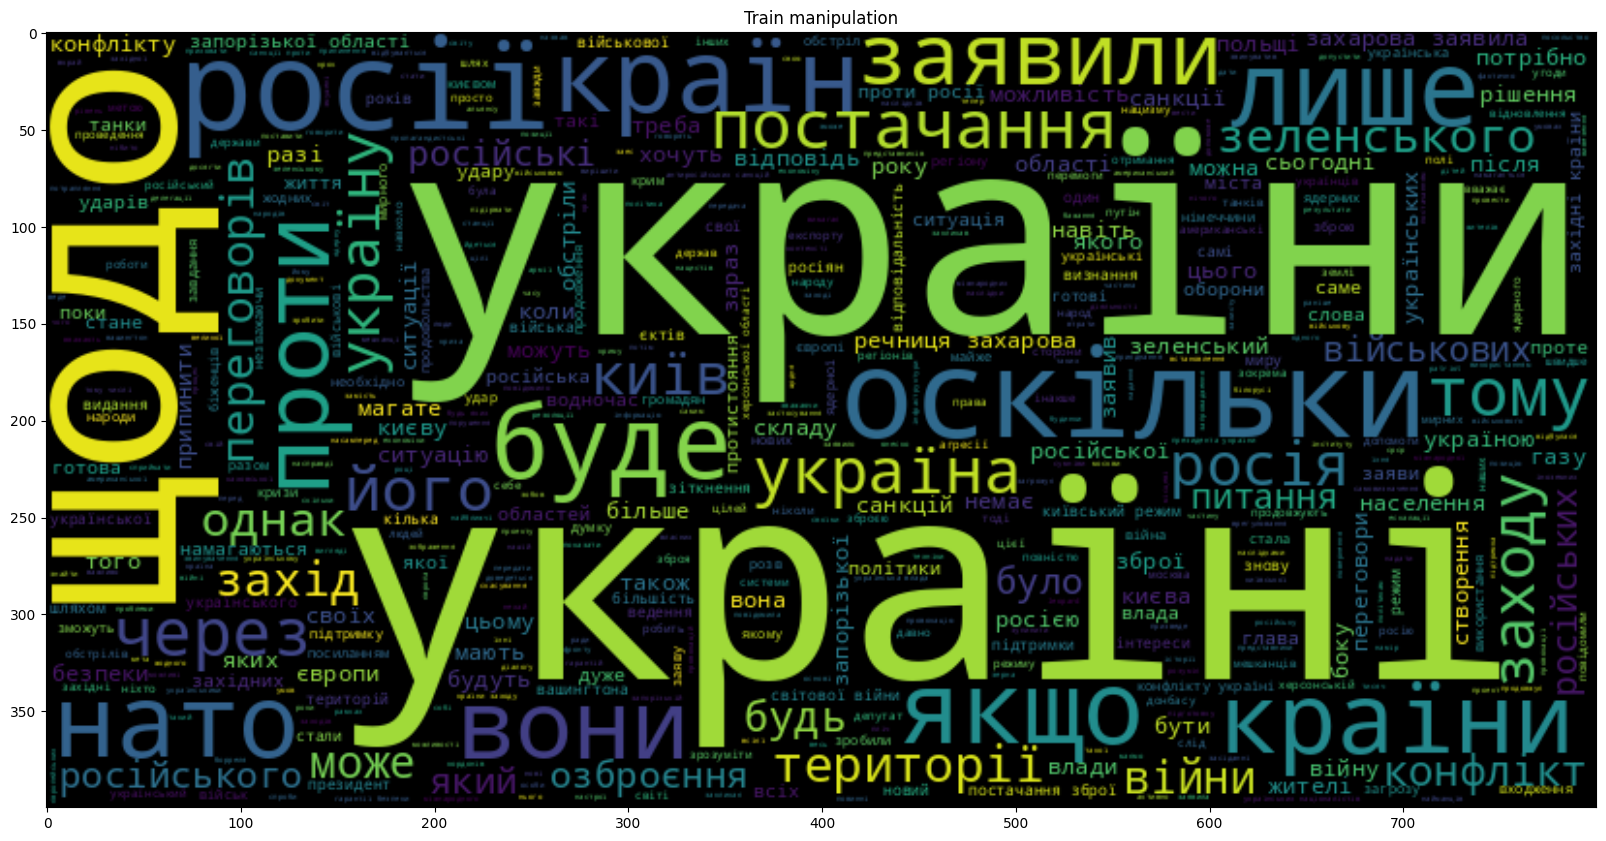

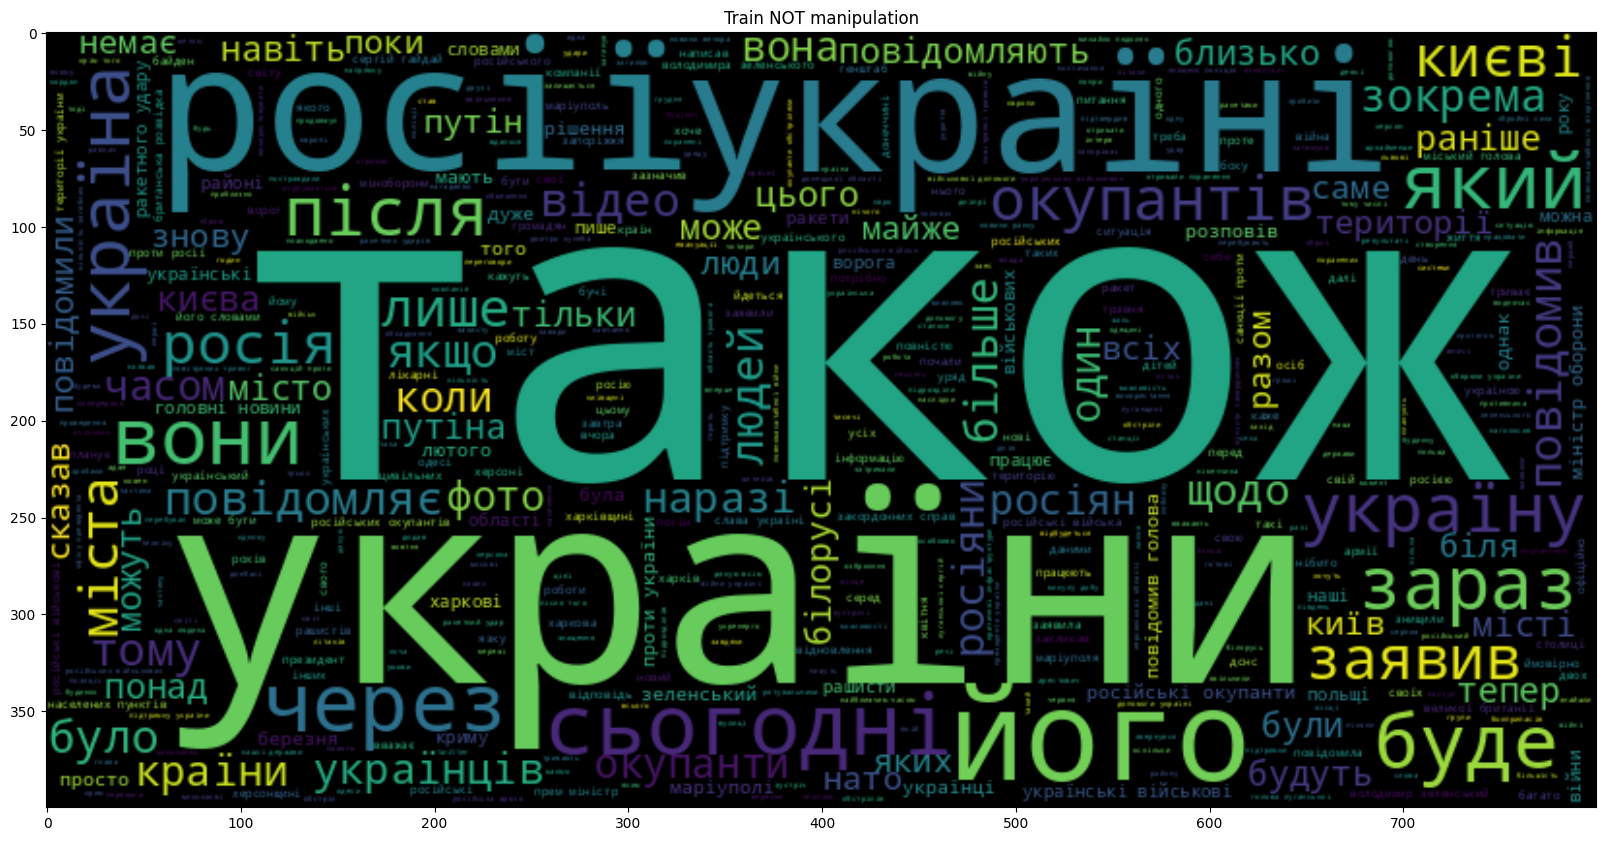

In [28]:
plt.figure(figsize = (20,20)) 
plt.title("Train manipulation")
wc = WordCloud(max_words = 500 , width = 800 , height = 400 , stopwords = stop_words).generate(" ".join(df.loc[df["is_manipulation"] == 1, 'cleaned_text']))
plt.imshow(wc, interpolation = 'bilinear')

plt.figure(figsize = (20,20)) 
plt.title("Train NOT manipulation")
wc = WordCloud(max_words = 500 , width = 800 , height = 400 , stopwords = stop_words).generate(" ".join(df.loc[df["is_manipulation"] == 0, 'cleaned_text']))
plt.imshow(wc, interpolation = 'bilinear')

In [29]:
def comp_metric(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    class_roc_aucs = roc_auc_score(y_true, y_pred)
    print(f"Result Roc Auc: {class_roc_aucs}")
    return class_roc_aucs, np.mean(class_roc_aucs)

## Clustering

In [30]:
# TODO maybe we can find smth interesting

In [31]:
df.loc[df["cleaned_text"].str.contains('0365')]

index                                            Message  \
16137  16137  ❤️ Різдвяний збір на 10 автівок для бійців ЗСУ...   

       is_manipulation                                       cleaned_text  
16137                0  різдвяний збір автівок бійців відкриваємо збір...

In [32]:
df.drop(columns='index', inplace=True)

In [33]:
df

Message  is_manipulation  \
1      🪖 Британська розвідка стверджує, що росії брак...                0   
2      В результаті обстрілів міста Олешки повибивало...                0   
3      Ось так виглядає Київ під час снігопаду\n\nФот...                0   
4      ❤️Томарине, що на Херсонщині, також під контро...                0   
5      🥺❤️Журнал Time назвав Персоною року президента...                0   
...                                                  ...              ...   
28549   «адвокати впевнені, що НАТО слід судити за по...                1   
28550   Україна принесена в жертву геополітичним інте...                1   
28551   «якщо рф застосує антисанкції щодо вантажів, ...                1   
28552   «антиросійські санкції призвели до енергетичн...                1   
28553  ❌ В мзс рф заявили про те, що «мілітаризація і...                1   

                                            cleaned_text  
1      британська розвідка стверджує росії бракує осо...  
2      результаті обстрілів міста олешки повибивало в...  
3                   виглядає київ снігопаду фото reuters  
4                    томарине херсонщині також контролем  
5      журнал time назвав персоною року президента во...  
...                                                  ...  
28549  адвокати впевнені нато слід судити порушення п...  
28550  україна принесена жертву геополітичним інтерес...  
28551  якщо застосує антисанкції щодо вантажів йдуть ...  
28552  антиросійські санкції призвели енергетичної кр...  
28553  заявили мілітаризація інформаційного простору ...  

[28552 rows x 3 columns]

## TF-IDF

In [34]:
tf_idf_object = TfidfVectorizer()
tf_idf_matrix = tf_idf_object.fit_transform(
    df["cleaned_text"].iloc[:6005]
)
print(tf_idf_object.get_feature_names_out().tolist())
print(f"Bag of Words: {tf_idf_object.get_feature_names_out()}")
# print(
#     f"Text : {df['cleaned_text'].iloc[1]}\n"
#     f"Vectorization: {tf_idf_object.transform([df['cleaned_text'].iloc[1]]).toarray()[0]}"
# )

['0010', '0020', '0246', '0485', '0512', '0679839403', '093879936', '1000', '10000', '10000грн', '1000мвт', '100500', '1010', '1042', '1064', '1100', '1140', '1180', '11ec', '1200', '1300', '13400', '1351', '1470', '1497964053196677126', '1500', '1545', '15700', '15хв', '160тис', '1645694761725643', '1700', '1710', '1730', '1750', '1767', '1782', '1783', '1887', '18900', '1917', '1918', '1919', '1921', '1922', '1923', '1930', '1932', '1933', '1938', '1939', '1941', '1944', '1945', '1946', '1947', '1960', '1970', '1973', '1988', '1991', '1996', '1998', '1999', '1oykadzxwxdxb', '2000', '2001', '2006', '2007', '2008', '2009', '200rf', '2010', '2014', '2015', '2017', '2018', '2019', '2020', '2021', '2021року', '2022', '2023', '2024', '2025', '2030', '2034', '2040', '2104', '22м3', '2389', '2500', '26002050339324', '2700', '2f2fosbqqbnfpg', '2hs73ku7jb', '2pauhx1agl', '2tone', '3000', '300вм', '300ф', '305299', '30см', '31бм', '31іап', '32519', '32520', '3300', '3343', '33a91f34203a', '3600

In [37]:
list_drop = []
for i, el in enumerate(tf_idf_object.get_feature_names_out().tolist()):
    if el == 'аарон':
        for ell in tf_idf_object.get_feature_names_out().tolist()[:i]:
            list_drop.append(ell)

In [39]:
index_drop = []
for it in list_drop:
    # print(it)
    # print('-'*80)
    for i, item in df.iterrows():
        # print(item[0])
        if it in item[0]:
            # print(it)
            # print(item[0])
    # df["cleaned_text"].str.contains(it))
            index_drop.append(df.loc[df['Message'] == item[0]].index.values[0])
# df.head()

In [395]:
df.drop(index_drop, inplace=True)

In [353]:
df.head()

Message  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
1  Україна відновлюється після ударів терористів. Дякую усім, хто на своєму рівні забезпечує це відновлення і продовження нормального життя.  \n  \nРятувальникам, які миттєво прибули на виклики й почали знешкодження наслідків терористичних атак.  \n  \nЛікарям, які надавали допомогу пораненим і травмованим!  \n  \nЕнергетикам і працівникам комунальних служб – за якісну реакцію та швидку роботу.  \n  \nПрацівникам місцевої влади, очільникам місцевого самоврядування та урядовцям, які працювали разом, справді у єдності й на відмінно.  \n  \nУсе відновимо. Відбудуємо. І неодмінно переможемо! 🇺🇦 \n\nФото: Павло Петров.   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 ⚡️ Волинь — також повідомляють про вибухи! Можливо, ППО. Перевіряємо інформацію та чекаємо на офіційну інформацію.\n\nЦЕНТР   
3                                                                                                                                                                                                                                                                                   🔥На півдні України підрозділи військ рф затиснені між українськими силами оборони та правим берегом, повідомила керівник об'єднаного прес-центру Сил оборони Південь Наталія Гуменюк\n\n«Їм запропоновано вихід у вигляді переходу під егіду міжнародного гуманітарного права або повертатися додому, але треба зрозуміти як», — додала Гуменюк.\n\nЦЕНТР   
4                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       🚨Черкаси! Повітряна тривога!\n\nЦЕНТР   

   is_manipulation  \
0                0   
1                0   
2                0   
3                0   
4                0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             cleaned_text  
0                                                                                                                                                                                                                             

In [345]:
df.loc[df['Message'] == item[0]].index.values[0]

25956

In [403]:
df.loc[df["cleaned_text"].str.contains('3wkfgmpbdzc')]

Message  \
4370  ⚡️Звернення Байдена з українським перекладом від «Голос Америки». Чекаємо початку.\n\nТрансляція — https://youtu.be/3WkFgMpbdzc   

      is_manipulation  \
4370                0   

                                                                                             cleaned_text  
4370  звернення байдена українським перекладом голос америки чекаємо початку трансляція youtu 3wkfgmpbdzc

In [408]:
tf_idf_object = TfidfVectorizer()
tf_idf_matrix = tf_idf_object.fit_transform(
    df["cleaned_text"].iloc[:6005]
)
print(tf_idf_object.get_feature_names_out().tolist())
print(f"Bag of Words: {tf_idf_object.get_feature_names_out()}")
# print(
#     f"Text : {df['cleaned_text'].iloc[1]}\n"
#     f"Vectorization: {tf_idf_object.transform([df['cleaned_text'].iloc[1]]).toarray()[0]}"
# )

['0512', '1570', '1783', '1863', '1oykadzxwxdxb', '22м3', '2step', '300вм', '35мс', '3snir1l', '3wkfgmpbdzc', '4000', '5wv4rrbkdj', '7273', '76тд', '80бв', '95мс', '96op72mmsjw', 'a400m', 'abbvie', 'about', 'abrams', 'accent', 'adonis', 'aiisa', 'airborne', 'airbus', 'airlines', 'airpods', 'airportboryspil', 'akamai', 'akıncı', 'alcotán', 'alex', 'alina', 'alpha', 'alyona', 'amazon', 'american', 'amnesty', 'android', 'anonymous', 'apple', 'appstore', 'archer', 'arial', 'aris', 'armed', 'as90', 'aspide', 'associated', 'asters', 'astrazeneca', 'atacms', 'auchan', 'australian', 'auto', 'avenger', 'avito', 'awards', 'axios', 'ayya', 'azovstal', 'bank', 'barchetta', 'bastion', 'baykar', 'bayraktar', 'bazaart', 'bektas', 'belga', 'bell', 'bellingcat', 'bestcities', 'biber', 'biden', 'bild', 'billboard', 'biontech', 'bitch', 'bitcoin', 'bitė', 'black', 'blanco', 'blastoff', 'bledina', 'bloggers', 'bloomberg', 'blue', 'boeing', 'bohater', 'bolt', 'bonaqua', 'boris', 'bounty', 'bradley', 'brave

## Sentence Transformers

## Logistic Regression

In [397]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
folds_train_test_ids = [el for el in skf.split(X_train, y_train)]
# FIXME add k-fold

In [398]:
model = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("lof_reg", LogisticRegression())
])

all_train_pred = model.fit(
    X_train, 
    y_train
).predict_proba(X_train)

all_train_pred = np.stack([el[1] for el in all_train_pred])

comp_metric(y_train.values, all_train_pred)

Result Roc Auc: 0.9999995344216074


(0.9999995344216074, 0.9999995344216074)

In [399]:

all_train_preds = []
all_test_preds = []
all_train_targets = []
all_test_targets = []
all_models = []
for fold_id, (train_ids, test_ids) in enumerate(folds_train_test_ids):
    parameters = {
        'model__C': [.01, .1, 1, 10],
        'model__penalty': ['l1', 'l2']
    }
    pipeline = Pipeline([
        ("vectorizer", TfidfVectorizer()),
        ("model", LogisticRegression())
    ])
    # print(LogisticRegression().get_params().keys())
    grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=parameters)
    grid.fit(X_train.iloc[train_ids], y_train.iloc[train_ids])
    fold_train_preds = grid.predict_proba(X_train.iloc[train_ids])
    fold_train_preds = np.stack([el[1] for el in fold_train_preds])
    fold_test_preds = grid.predict_proba(X_train.iloc[test_ids])
    fold_test_preds = np.stack([el[1] for el in fold_test_preds])
    fold_train_targets = y_train.iloc[train_ids].values
    fold_test_targets = y_train.iloc[test_ids].values
    print(f"Fold {fold_id}")
    print("Train: ")
    comp_metric(fold_train_targets, fold_train_preds);
    print("Test: ")
    comp_metric(fold_test_targets, fold_test_preds);
    all_train_preds.append(fold_train_preds)
    all_test_preds.append(fold_test_preds)
    all_train_targets.append(fold_train_targets)
    all_test_targets.append(fold_test_targets)
    all_models.append(grid)

/home/diakap/miniconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/diakap/miniconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/diakap/miniconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/diakap/miniconda3/envs/ai_house_env/lib/python3.9/site-packages/

Fold 0
Train: 
Result Roc Auc: 1.0
Test: 
Result Roc Auc: 0.9441387784491125


/home/diakap/miniconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/diakap/miniconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/diakap/miniconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/diakap/miniconda3/envs/ai_house_env/lib/python3.9/site-packages/

Fold 1
Train: 
Result Roc Auc: 1.0
Test: 
Result Roc Auc: 0.9535244355464004


/home/diakap/miniconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/diakap/miniconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/diakap/miniconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/diakap/miniconda3/envs/ai_house_env/lib/python3.9/site-packages/

Fold 2
Train: 
Result Roc Auc: 0.9999999999999999
Test: 
Result Roc Auc: 0.9605451466441387


/home/diakap/miniconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/diakap/miniconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/diakap/miniconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/diakap/miniconda3/envs/ai_house_env/lib/python3.9/site-packages/

Fold 3
Train: 
Result Roc Auc: 0.9999999999999999
Test: 
Result Roc Auc: 0.9435411386667591


/home/diakap/miniconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/diakap/miniconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/diakap/miniconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/diakap/miniconda3/envs/ai_house_env/lib/python3.9/site-packages/

Fold 4
Train: 
Result Roc Auc: 1.0
Test: 
Result Roc Auc: 0.9510795534609905


## RNN

In [ ]:
class RNN(nn.Module):
    
    def __init__(
        self,
        num_embeddings,
        out_channels,
        rnn_channels=512,
        rnn_type=nn.GRU,
    ):
        super().__init__()
        pass        
        
    def forward(self, x):
        pass
        
        

## Transformers

## Evaluation

## References

- https://github.com/skupriienko/Ukrainian-Stopwords